In [ ]:
!pip install datasets
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [ ]:

device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

In [ ]:
samsum = load_dataset('samsum')
samsum

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:

dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

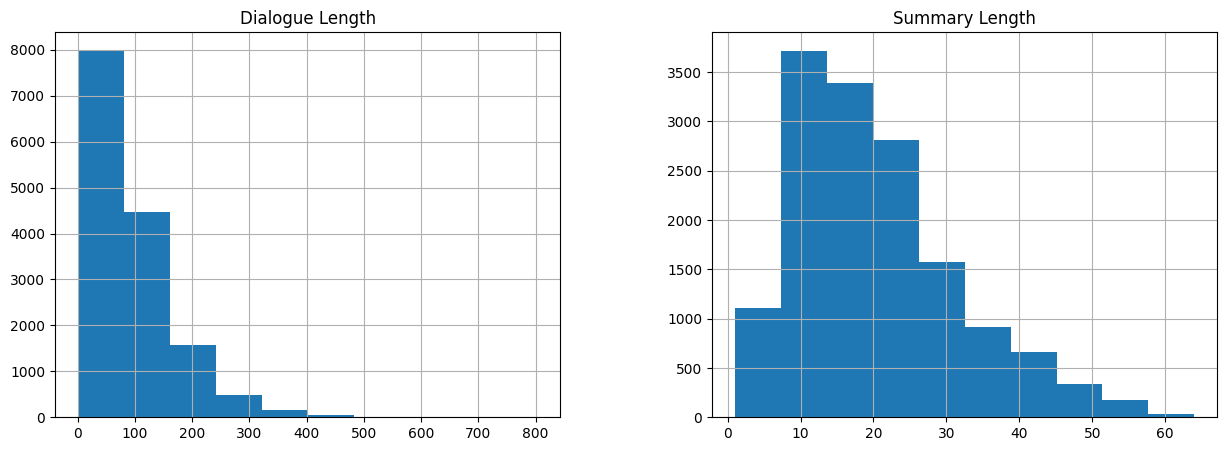

In [ ]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [ ]:
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
from transformers import AutoTokenizer

In [ ]:
print(get_feature.__code__.co_varnames)

('batch', 'encodings')


In [ ]:
tokenizer_type = type(tokenizer).__name__
print(f"Tokenizer type: {tokenizer_type}")

Tokenizer type: BartTokenizerFast


In [ ]:
if tokenizer_type == "BartTokenizerFast":
    !pip install transformers[sentencepiece]

In [ ]:
model_checkpoint = "bert-base-uncased"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def get_feature(batch):
    encodings = tokenizer(batch['dialogue'], return_tensors="pt", max_length=1024, truncation=True)
    return encodings

In [ ]:
# Print the number of examples in the dataset
print(len(samsum["train"]))

# Print the number of tokens in the first example
print(len(tokenizer(samsum["train"][0]["dialogue"])["input_ids"]))

14732
28


In [ ]:
# Set the `truncation` and `padding` arguments to `True`
samsum_pt = samsum.map(get_feature, batched=True, remove_columns=["dialogue"])

In [ ]:
samsum_pt

In [ ]:

columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
!pip install accelerate

In [ ]:
pip install accelerate -U

In [ ]:
!pip install accelerate>=0.21.0

In [ ]:
pip install transformers[torch]

In [ ]:
!pip install transformers==4.18.0

In [ ]:
!pip install transformers --upgrade

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

In [ ]:

trainer.train()

In [ ]:
trainer.save_model('bart_samsum_model')

In [ ]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))

In [ ]:
!zip bart_samsum.zip -r bart_samsum_model/